<a href="https://colab.research.google.com/github/Gunasekaran-03/Gmail_Authenticate/blob/main/ALBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [7]:
import pandas as pd

df = pd.read_csv("spam.csv",encoding='ISO-8859-1')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.groupby('v1').describe()

v2         ... Unnamed: 4     
     count unique  ...        top freq
v1                 ...                
ham   4825   4516  ...    GNT:-)"    2
spam   747    653  ...        NaN  NaN

[2 rows x 16 columns]

In [9]:
df_spam = df[df['v1']=='spam']
df_spam.shape

(747, 5)

In [10]:
df_ham = df[df['v1']=='ham']
df_ham.shape

(4825, 5)

In [11]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 5)

In [12]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 5)

In [13]:
df_balanced['v1'].value_counts()

ham     747
spam    747
Name: v1, dtype: int64

In [14]:
df_balanced['spam']=df_balanced['v1'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,spam
4893,ham,Convey my regards to him,NaN,NaN,NaN,0
4325,ham,That seems unnecessarily hostile,NaN,NaN,NaN,0
3458,spam,Not heard from U4 a while. Call me now am here...,NaN,NaN,NaN,1
3239,ham,A cute thought for friendship: \Its not necess...,"but watever u shared should be true\""....""",NaN,NaN,0
3825,ham,"Goodmorning,my grandfather expired..so am on l...",NaN,NaN,NaN,0


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['v2'],df_balanced['spam'], stratify=df_balanced['spam'])

In [16]:
X_train.head(4)

1320    Just sent again. Do you scream and moan in bed...
2804                     I think it's all still in my car
2224    I prefer my free days... Tues, wed, fri oso ca...
1123                  Good morning princess! How are you?
Name: v2, dtype: object

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3")

In [18]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    print(preprocessed_text)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

{'input_word_ids': <tf.Tensor: shape=(2, 128), dtype=int32, numpy=
array([[    2,  3033,  4403, 14691,     9,  8425,    71,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.09927757,  0.07590868, -0.9603176 , ...,  0.98063165,
         0.72893906, -0.12989949],
       [ 0.5648693 , -0.62469655,  0.23342405, ...,  0.6583792 ,
        -0.9986799 ,  0.6418971 ]], dtype=float32)>

In [19]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [21]:
len(X_train)

1120

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [23]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 491s 14s/step - loss: 0.5577 - accuracy: 0.7357 - precision: 0.7472 - recall: 0.7125
Epoch 2/10
35/35 [==============================] - 485s 14s/step - loss: 0.4006 - accuracy: 0.8536 - precision: 0.8486 - recall: 0.8607
Epoch 3/10
35/35 [==============================] - 485s 14s/step - loss: 0.3329 - accuracy: 0.8750 - precision: 0.8710 - recall: 0.8804
Epoch 4/10
35/35 [==============================] - 482s 14s/step - loss: 0.2886 - accuracy: 0.9062 - precision: 0.8970 - recall: 0.9179
Epoch 5/10
35/35 [==============================] - 487s 14s/step - loss: 0.2640 - accuracy: 0.9071 - precision: 0.9000 - recall: 0.9161
Epoch 6/10
35/35 [==============================] - 493s 14s/step - loss: 0.2445 - accuracy: 0.9062 - precision: 0.9041 - recall: 0.9089
Epoch 7/10
35/35 [==============================] - 486s 14s/step - loss: 0.2230 - accuracy: 0.9205 - precision: 0.9139 - recall: 0.9286
Epoch 8/10
35/35 [=======================

In [24]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 163s 13s/step - loss: 0.2159 - accuracy: 0.9278 - precision: 0.9396 - recall: 0.9144


[0.2158503383398056,
 0.9278075098991394,
 0.9395604133605957,
 0.9144384860992432]

In [25]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [26]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[176,  11],
       [ 16, 171]])

Text(33.0, 0.5, 'Truth')

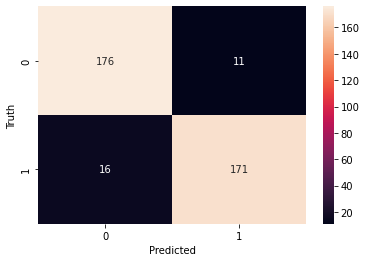

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       187
           1       0.94      0.91      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [30]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.8762607 ],
       [0.9752556 ],
       [0.74862754],
       [0.02779791],
       [0.09117472]], dtype=float32)